# 关于亚马逊平台上“中国研究”主题的相关书籍的用户评论的情感分析
主要任务是建立一个二分类情感分析系统，用于分析用户评论的情感极性。

## 从亚马逊网站上选择一些关于研究中国的书籍的用户评论

数据说明：在搜索框内输入“china”， 爬取排序较为靠前的10本书的全部评论；存入'./raw/data/'路径下。
数据处理：每一个评论文件表格的‘a-icon-alt’， ‘a-size-base’， ‘a-size-base 3’分别是评分星数（1星为最差，5星为最好）， 评论标题， 评论文本。这是我们主要关注的数据，将把它们提取出来。

In [29]:
import pandas as pd
import os

raw_data_path = r'./raw_data/'
files = os.listdir(raw_data_path)

In [30]:
# 定义处理一个csv文件成为rating_float, tle_txt_str两列的DataFrame
def filter_data(file_name):
    df = pd.read_csv(raw_data_path+file_name)
    # 选取我们所关注的行
    df = df[['a-icon-alt', 'a-size-base', 'a-size-base 3']]
    df.columns = ['rating_str', 'title_str', 'text_str']
    # 删除有nan的列
    df = df.dropna(axis=0, how='any')
    # 把rating_str处理成数值类型
    rating_f_list = \
    [float(s[:3])
        for s in df['rating_str'].tolist()
    ]
    df['rating_float'] = rating_f_list
    # 将标题和文本拼接
    title_text = \
    [   df['title_str'][idx] + ' ' + df['text_str'][idx]
        for idx in df.index
    ]
    df['tle_txt_str'] = title_text
    # 删除不需要的列
    df = df[['tle_txt_str', 'rating_float']]
    print(file_name+'OK')
    return df


In [31]:
dfs = [
    filter_data(file_name)
    for file_name in files
]   # DataFrame列表

China After Mao The Rise of a Superpower.csvOK
China The Novel.csvOK
Invisible China How the Urban-Rural Divide Threatens China’s Rise.csvOK
Red-Handed How American Elites Get Rich Helping China Win.csvOK
The Avoidable War The Dangers of a Catastrophic Conflict between the US and Xi Jinping's China.csvOK
The China Mirage The Hidden History of American Disaster in Asia.csvOK
The Coming Conflict with China.csvOK
The Long Game China's Grand Strategy to Displace American Order.csvOK
The Opium War Drugs, Dreams, and the Making of Modern China.csvOK
The Party The Secret World of China's Communist Rulers.csvOK


In [33]:
# 拼接得到所有的tle_txt, rating_float数据
data_df = pd.concat(objs=dfs, ignore_index=True)
data_df.shape
# 这个数据很小，可能导致模型的效果不好，但是我们只是做一个小的demo，后续可以按需要优化

(1591, 2)

<Axes: >

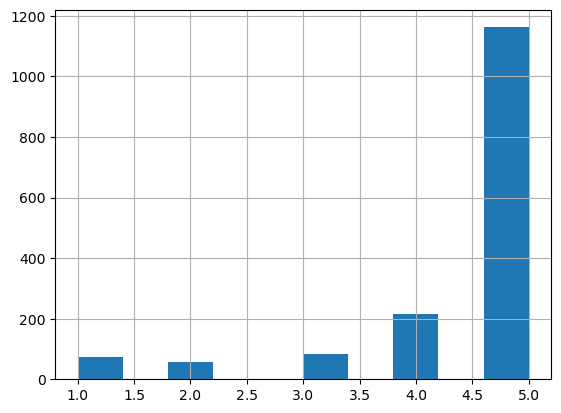

In [34]:
# 画出rating的hist图
data_df['rating_float'].hist()

 发现数据标签不平衡，我们暂且考虑，规定小于4分的标签定位负面(neg)，4分以及以上的规定为证明评价(pos)。

In [35]:
# 将二分类数据存入文件
pos_path = r'./pos'
neg_path = r'./neg'
os.mkdir(pos_path)
os.mkdir(neg_path)
# 分别创建.txt文件写入到相应的文件夹
for idx, row in data_df.iterrows():
    if row['rating_float'] < 4.:
        txt_path = r'./neg/'
    else:
        txt_path = r'./pos/'
    txt = open(txt_path+'review_'+str(idx)+'.txt', 'w', encoding='utf-8')
    txt.write(row['tle_txt_str'])
    txt.close()

In [4]:
# 划分训练集和测试集
import os
train_neg_path, train_pos_path, test_neg_path, test_pos_path = \
    r'./train/neg/', r'./train/pos/', r'./test/neg/', r'./test/pos/'
num_pos_sample, num_neg_sample = len(os.listdir(r'./pos/')), len(os.listdir(r'./neg/'))
num_neg_sample, num_pos_sample
# 发现正负类不平衡问题

(214, 1377)

In [9]:
os.mkdir(r'./train/')
os.mkdir(r'./test/')
for path in [train_neg_path, train_pos_path, test_neg_path, test_pos_path]:
    os.mkdir(path)

In [5]:
# 从正负类样本中分别选择10%作为验证集和测试集
import random
test_percent = 0.1
pos_txts = os.listdir(r'./pos/')
neg_txts = os.listdir(r'./neg/')
test_txts_pos = random.choices(pos_txts, k=int(test_percent*num_pos_sample))
test_txt_neg = random.choices(neg_txts, k=int(test_percent*num_neg_sample))

In [20]:
# 将对应文件复制到相应的文件夹
from shutil import copyfile
# 测试集正样例
for txt in test_txts_pos:
    f = open(test_pos_path+txt, 'w', encoding='utf-8')
    copyfile(r'./pos/'+txt, test_pos_path+txt)
    f.close()
# 测试集负样例
for txt in test_txt_neg:
    f = open(test_neg_path+txt, 'w', encoding='utf-8')
    copyfile(r'./neg/'+txt, test_neg_path+txt)
    f.close()
# 训练集正样例
train_txt_pos = list(set(pos_txts)-set(test_txts_pos))
for txt in train_txt_pos:
    f = open(train_pos_path+txt, 'w', encoding='utf-8')
    copyfile(r'./pos/'+txt, train_pos_path+txt)
    f.close()
# 训练集负样例
train_txt_neg = list(set(neg_txts)-set(test_txt_neg))
for txt in train_txt_neg:
    f = open(train_neg_path+txt, 'w', encoding='utf-8')
    copyfile(r'./neg/'+txt, train_neg_path+txt)
    f.close()